In this notebook, we will train a first-level LSTM model using discourse and essay embeddings saved during the EDA stage. The model will then be used to generate predictions for the holdout and test datasets. These predictions will serve as one of the features for the second-level model, which will be trained on the holdout dataset and ultimately evaluated on the test set.

In [1]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 3.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import patoolib
import json
import pickle
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from functools import partial
from tqdm import tqdm
from tqdm import trange
from collections import Counter

We will now load the data along with the previously saved discourse and essay embeddings.

In [4]:
mkdir data2022

In [5]:
BASIC_PATH = '/content/gdrive/MyDrive/ML/projects/feedback-prize/'
MODEL_PATH = '1st_level_models/lstm_model_weighted.pth'
SAVE_DATASETS_FOLDER = '1st_level_preds/'

In [6]:
patoolib.extract_archive(BASIC_PATH+'data/feedback-prize-effectiveness.zip', outdir = '/content/data2022')

INFO patool: Extracting /content/gdrive/MyDrive/ML/projects/feedback-prize/data/feedback-prize-effectiveness.zip ...
INFO:patool:Extracting /content/gdrive/MyDrive/ML/projects/feedback-prize/data/feedback-prize-effectiveness.zip ...
INFO patool: running /usr/bin/7z x -o/content/data2022 -- /content/gdrive/MyDrive/ML/projects/feedback-prize/data/feedback-prize-effectiveness.zip
INFO:patool:running /usr/bin/7z x -o/content/data2022 -- /content/gdrive/MyDrive/ML/projects/feedback-prize/data/feedback-prize-effectiveness.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/gdrive/MyDrive/ML/projects/feedback-prize/data/feedback-prize-effectiveness.zip extracted to `/content/data2022'.
INFO:patool:... /content/gdrive/MyDrive/ML/projects/feedback-prize/data/feedback-prize-effectiveness.zip extracted to `/content/data2022'.


'/content/data2022'

In [7]:
input_dir = '/content/data2022'

train_csv = os.path.join(input_dir, 'train.csv')

data_2022 = pd.read_csv(train_csv)

In [8]:
data_2022.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [9]:
class_names = list(set(data_2022['discourse_effectiveness']))
class_names.sort()
label_to_id = {label: i for i, label in enumerate(class_names)}

In [10]:
data_2022['target'] = data_2022['discourse_effectiveness'].replace(label_to_id)

<ipython-input-10-62c299b4d34e>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_2022['target'] = data_2022['discourse_effectiveness'].replace(label_to_id)


In [11]:
with open(BASIC_PATH+'data_splits.json', 'r') as file:
    split_ids = json.load(file)

In [12]:
discourse_embeddings = np.load(BASIC_PATH+'embeddings/2022_discourse_embeddings.npz')

loaded_discourse_ids = discourse_embeddings['discourse_ids']
loaded_discourse_embeddings = discourse_embeddings['discourse_embeddings']

df_discourse_embeddings = pd.DataFrame(loaded_discourse_embeddings)
df_discourse_embeddings.columns = [f'disc_emb_dim_{i+1}' for i in range(df_discourse_embeddings.shape[1])]
df_discourse_embeddings['discourse_id'] = loaded_discourse_ids
df_discourse_embeddings = df_discourse_embeddings[['discourse_id'] + [col for col in df_discourse_embeddings.columns if col != 'discourse_id']]

In [13]:
df_discourse_embeddings.head()

,discourse_id,disc_emb_dim_1,disc_emb_dim_2,disc_emb_dim_3,disc_emb_dim_4,disc_emb_dim_5,disc_emb_dim_6,disc_emb_dim_7,disc_emb_dim_8,disc_emb_dim_9,...,disc_emb_dim_759,disc_emb_dim_760,disc_emb_dim_761,disc_emb_dim_762,disc_emb_dim_763,disc_emb_dim_764,disc_emb_dim_765,disc_emb_dim_766,disc_emb_dim_767,disc_emb_dim_768
0,0013cc385424,-0.074544,-0.251746,0.039989,-0.269454,1.274046,0.636828,0.285024,1.007192,0.069854,...,-0.028507,-0.030316,-0.269066,-0.164834,-0.058057,0.309342,0.607125,-0.614451,0.164037,-0.042976
1,9704a709b505,-0.138114,0.159553,0.071121,0.040252,1.012260,0.953447,0.269533,0.885836,0.498467,...,-0.753420,-0.740413,-0.157875,-0.103554,0.553908,0.303424,0.814504,-0.287636,-0.174267,-0.733787
2,c22adee811b6,-0.405241,-0.825316,-0.022330,-0.400907,1.285600,0.435820,0.202860,0.898636,-0.563716,...,-0.622115,-0.528273,-1.179233,-0.565132,0.070622,0.366844,0.558589,-0.289884,-0.228211,-0.670518
3,a10d361e54e4,-0.182680,-0.113140,-0.131830,0.145519,0.970769,0.530573,0.057293,0.502485,0.942897,...,-0.297033,-0.423347,-0.280275,-0.214234,0.504504,-0.005146,0.118951,-0.036993,-0.369095,-0.447838
4,db3e453ec4e2,-0.699138,-0.639889,-0.198978,-0.565757,1.386011,0.467251,0.718829,0.862455,-0.483619,...,-0.073979,0.047259,-0.754080,-0.312474,0.095637,0.791220,-0.240540,-0.053344,-0.898949,-0.302612


In [14]:
essay_embeddings = np.load(BASIC_PATH+'embeddings/2022_essay_embeddings.npz', allow_pickle=True)

loaded_essay_ids = essay_embeddings['essay_ids']
loaded_essay_embeddings = essay_embeddings['essay_embeddings']

df_essay_embeddings = pd.DataFrame(loaded_essay_embeddings)
df_essay_embeddings.columns = [f'essay_emb_dim_{i+1}' for i in range(df_essay_embeddings.shape[1])]
df_essay_embeddings['essay_id'] = loaded_essay_ids
df_essay_embeddings = df_essay_embeddings[['essay_id'] + [col for col in df_essay_embeddings.columns if col != 'essay_id']]

In [15]:
df_essay_embeddings.head()

,essay_id,essay_emb_dim_1,essay_emb_dim_2,essay_emb_dim_3,essay_emb_dim_4,essay_emb_dim_5,essay_emb_dim_6,essay_emb_dim_7,essay_emb_dim_8,essay_emb_dim_9,...,essay_emb_dim_375,essay_emb_dim_376,essay_emb_dim_377,essay_emb_dim_378,essay_emb_dim_379,essay_emb_dim_380,essay_emb_dim_381,essay_emb_dim_382,essay_emb_dim_383,essay_emb_dim_384
0,007ACE74B050,0.011675,0.008128,0.021032,-0.001148,0.030272,-0.073278,-0.022646,-0.027777,-0.012271,...,0.064735,-0.012869,0.016128,0.006209,0.004061,0.053964,-0.010016,0.010343,-0.010910,0.041069
1,00944C693682,0.053501,0.041472,0.072293,0.034796,0.040148,0.019340,0.012896,0.007692,-0.033432,...,0.033510,-0.016763,-0.012068,0.009766,-0.010827,-0.014054,0.026037,0.022251,0.010107,0.031330
2,00BD97EA4041,-0.014482,0.027644,0.024738,-0.021590,0.016479,-0.016790,0.017035,-0.015605,0.026015,...,0.030305,0.001151,-0.000607,0.019716,-0.033894,0.031733,0.056291,0.031456,-0.002304,-0.003539
3,00C6E82FE5BA,-0.062857,-0.005400,0.014592,-0.030059,0.066248,0.001064,0.061247,0.008068,0.031039,...,0.057417,-0.015536,0.024880,0.026257,-0.005454,0.054577,0.048538,0.016117,-0.023856,0.010883
4,013B9AA6B9DB,-0.016238,0.040474,0.020973,0.024325,0.057331,-0.063316,-0.012638,-0.022030,0.003975,...,0.011134,-0.034961,0.026750,-0.020137,-0.024651,0.038006,0.034120,0.005487,-0.011730,0.055912


In [16]:
# merge based on the corresponding ids
df_combined = pd.merge(data_2022[['discourse_id', 'essay_id', 'target']], df_essay_embeddings, on = 'essay_id')
df_combined = pd.merge(df_combined, df_discourse_embeddings, on = 'discourse_id')

In [17]:
df_combined.shape[0] == data_2022.shape[0]

True

Split the data into the previously defined train, holdout, and test sets. Additionally, split the training set into training and evaluation datasets, which will be used to train the 1st-level LSTM model with early stopping.

In [18]:
train_ids = split_ids['train_ids']
train_data = df_combined[df_combined['essay_id'].isin(train_ids)].copy()
train_data.reset_index(drop = True, inplace = True)

# for 2nd level model
holdout_ids = split_ids['holdout_ids']
holdout_data = df_combined[df_combined['essay_id'].isin(holdout_ids)].copy()
holdout_data.reset_index(drop = True, inplace = True)

#for final evaluation of blending ensemble
test_ids = split_ids['test_ids']
test_data = df_combined[df_combined['essay_id'].isin(test_ids)].copy()
test_data.reset_index(drop = True, inplace = True)

In [19]:
unique_essay_ids = train_data['essay_id'].unique()

train_ids, val_ids = train_test_split(unique_essay_ids, test_size = 0.2, random_state = 79)

train_mask = train_data['essay_id'].isin(train_ids)
val_mask = train_data['essay_id'].isin(val_ids)

train_df = train_data[train_mask].reset_index(drop = True)
val_df = train_data[val_mask].reset_index(drop = True)

In [20]:
train_df.drop(columns = ['discourse_id', 'essay_id'], axis = 1, inplace = True)
val_df.drop(columns = ['discourse_id', 'essay_id'], axis = 1, inplace = True)

This CustomDataset class prepares data for training by loading essay and discourse embeddings along with their labels from a DataFrame.

In [21]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        essay_emb = torch.from_numpy(self.data.iloc[index, 1:385].values.astype(np.float32))
        discourse_emb = torch.from_numpy(self.data.iloc[index, 385:1153].values.astype(np.float32))
        label = torch.tensor(self.data.iloc[index, 0], dtype=torch.long)
        return essay_emb, discourse_emb, label

This LSTM class defines a dual LSTM architecture for processing essay and discourse embeddings. It initializes LSTMs, applies orthogonal and He initialization, and uses dropout for regularization. The forward method processes inputs, extracts the last hidden states, concatenates them, and outputs class predictions through a fully connected layer.

In [22]:
class LSTM(nn.Module):
    def __init__(self, essay_embedding_size = 384, discourse_embedding_size = 768, hidden_size = 128, output_size = 3, dropout_rate = 0.5):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        # LSTM for discourse embeddings
        self.lstm_discourse = nn.LSTM(discourse_embedding_size, hidden_size, num_layers = 1, batch_first = True)
        # LSTM for essay embeddings
        self.lstm_essay = nn.LSTM(essay_embedding_size, hidden_size, num_layers = 1, batch_first = True)

        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layers for classification
        self.fc = nn.Linear(hidden_size * 2, output_size)  # hidden_size*2 for two LSTMs

        # Apply orthogonal initialization for LSTM and He initialization for Linear layer
        for name, param in self.lstm_discourse.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

        for name, param in self.lstm_essay.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

        nn.init.kaiming_normal_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, essay_embeddings, discourse_embeddings):
        essay_embeddings = essay_embeddings.unsqueeze(1)  # Shape: (batch_size, 1, embedding_size)
        discourse_embeddings = discourse_embeddings.unsqueeze(1)  # Shape: (batch_size, 1, embedding_size)

        # LSTM for essay embeddings
        lstm_out_essay, _ = self.lstm_essay(essay_embeddings)
        lstm_out_essay = lstm_out_essay[:, -1, :]  # Take the last hidden state

        # LSTM for discourse embeddings
        lstm_out_discourse, _ = self.lstm_discourse(discourse_embeddings)
        lstm_out_discourse = lstm_out_discourse[:, -1, :]  # Take the last hidden state

        # Apply dropout
        lstm_out_essay = self.dropout(lstm_out_essay)
        lstm_out_discourse = self.dropout(lstm_out_discourse)

        # Concatenate the outputs of the two LSTMs
        combined = torch.cat((lstm_out_essay, lstm_out_discourse), dim = 1)

        # Fully connected layer for classification
        output = self.fc(combined)
        return output

This train_model function trains a given model using specified parameters, including the loss criterion, optimizer, and learning rate scheduler. It runs for a set number of epochs, tracking training and validation losses, as well as precision, recall, and F1 scores. It implements early stopping based on validation loss improvement, saving the best model state for final evaluation.

In [23]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs = 30, patience = 5):

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    train_epoch_loss = []
    val_epoch_loss = []
    val_epoch_precision = []
    val_epoch_recall = []
    val_epoch_f1 = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        # Training loop
        for essay_embeddings, discourse_embeddings, labels in tqdm(train_loader, desc = f'Training Epoch {epoch + 1}/{num_epochs}', leave = False):
            optimizer.zero_grad()
            outputs = model(essay_embeddings, discourse_embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        scheduler.step()

        avg_train_loss = total_loss / len(train_loader)

        # Validation loop
        model.eval()
        total_val_loss = 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for essay_embeddings, discourse_embeddings, labels in tqdm(val_loader, desc='Validating', leave=False):
                outputs = model(essay_embeddings, discourse_embeddings)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)

        # Calculate metrics
        precision = precision_score(all_val_labels, all_val_preds, average = 'macro')
        recall = recall_score(all_val_labels, all_val_preds, average = 'macro')
        f1 = f1_score(all_val_labels, all_val_preds, average = 'macro')

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

        train_epoch_loss.append(avg_train_loss)
        val_epoch_loss.append(avg_val_loss)
        val_epoch_precision.append(precision)
        val_epoch_recall.append(recall)
        val_epoch_f1.append(f1)

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"patience_counter: {patience_counter}")

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Load the best model state
    model.load_state_dict(best_model_state)

    return model, train_epoch_loss, val_epoch_loss, val_epoch_precision, val_epoch_recall, val_epoch_f1

Specify the hyperparameters and train the model

In [24]:
BATCH_SIZE = 64
LR = 0.001
WD = 0.001
LRS_STEP = 5
LRS_GAMMA = 0.1
NUM_EPOCHS = 50
PATIENCE = 3

In [25]:
train_dataset = CustomDataset(train_df)
val_dataset = CustomDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [26]:
# class_weights = compute_class_weight('balanced', classes = np.array([0, 1, 2]), y = train_df['target'])
# class_weights = torch.tensor(class_weights, dtype = torch.float)
class_weights = torch.tensor(np.array([1, 1.25, 1.75]), dtype = torch.float)
class_weights

tensor([1.0000, 1.2500, 1.7500])

In [27]:
model = LSTM(essay_embedding_size = 384, discourse_embedding_size = 768, hidden_size = 128, output_size = 3)
criterion = nn.CrossEntropyLoss(weight = class_weights) # (weight = class_weights)
optimizer = optim.Adam(model.parameters(), lr = LR, weight_decay = WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = LRS_STEP, gamma = LRS_GAMMA)

In [28]:
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {num_parameters}')

Number of trainable parameters: 723715


In [29]:
ltst_model, train_losses, val_losses, val_precision, val_recall, val_f1 = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs = NUM_EPOCHS, patience = PATIENCE)

Epoch [1/50], Loss: 0.8671, Val Loss: 0.8157, Precision: 0.5918, Recall: 0.5659, F1: 0.5764


Epoch [2/50], Loss: 0.8207, Val Loss: 0.8042, Precision: 0.6160, Recall: 0.5552, F1: 0.5727


Epoch [3/50], Loss: 0.8063, Val Loss: 0.8045, Precision: 0.6188, Recall: 0.5521, F1: 0.5736
patience_counter: 1


Epoch [4/50], Loss: 0.8057, Val Loss: 0.8118, Precision: 0.6220, Recall: 0.5454, F1: 0.5516
patience_counter: 2


Epoch [5/50], Loss: 0.7946, Val Loss: 0.8025, Precision: 0.5928, Recall: 0.5850, F1: 0.5881


Epoch [6/50], Loss: 0.7694, Val Loss: 0.7888, Precision: 0.6006, Recall: 0.5881, F1: 0.5936


Epoch [7/50], Loss: 0.7590, Val Loss: 0.7883, Precision: 0.6157, Recall: 0.5865, F1: 0.5980


Epoch [8/50], Loss: 0.7556, Val Loss: 0.7877, Precision: 0.6098, Recall: 0.5857, F1: 0.5960


Epoch [9/50], Loss: 0.7512, Val Loss: 0.7873, Precision: 0.6113, Recall: 0.5840, F1: 0.5952


Epoch [10/50], Loss: 0.7552, Val Loss: 0.7884, Precision: 0.6045, Recall: 0.5920, F1: 0.5978
patience_counter: 1


Epoch [11/50], Loss: 0.7480, Val Loss: 0.7876, Precision: 0.6096, Recall: 0.5865, F1: 0.5963
patience_counter: 2


Epoch [12/50], Loss: 0.7465, Val Loss: 0.7876, Precision: 0.6102, Recall: 0.5890, F1: 0.5979
patience_counter: 3
Early stopping triggered


In [31]:
#torch.save(ltst_model.state_dict(), BASIC_PATH+MODEL_PATH)

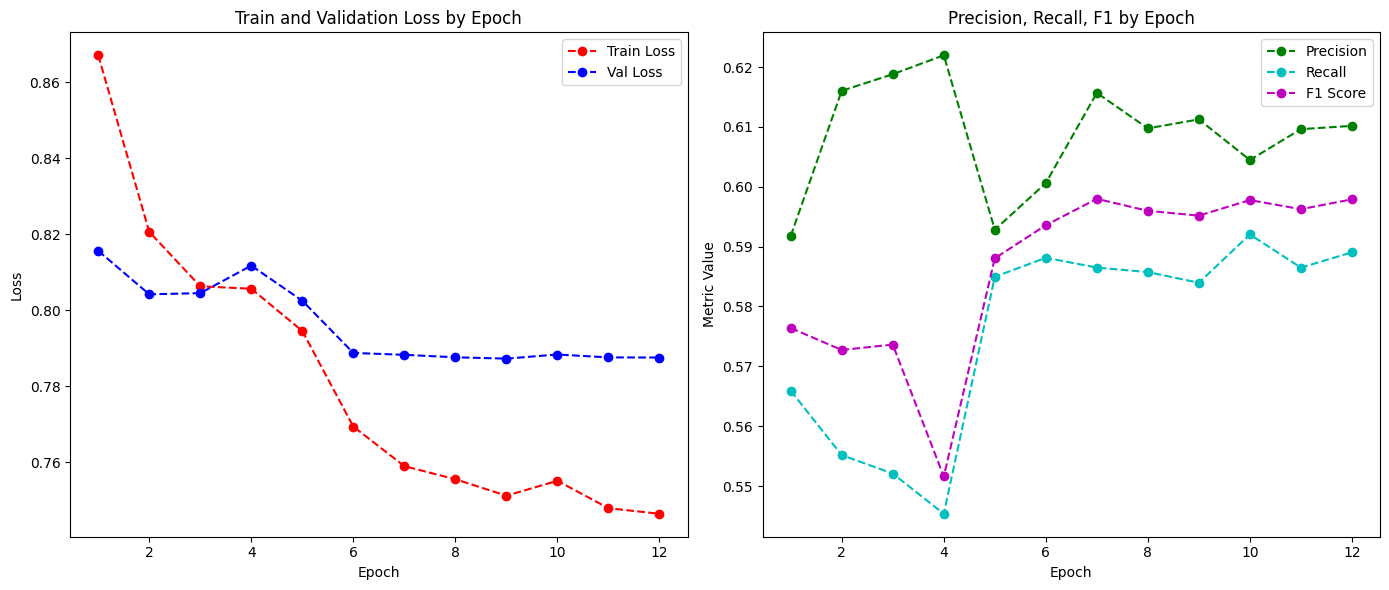

In [32]:
epochs = epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize = (14, 6))

# Subplot 1: Train and Val Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r--', label = 'Train Loss', marker = 'o')
plt.plot(epochs, val_losses, 'b--', label = 'Val Loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss by Epoch')
plt.legend()

# Subplot 2: Precision, Recall, F1
plt.subplot(1, 2, 2)
plt.plot(epochs, val_precision, 'g--', label = 'Precision', marker = 'o')
plt.plot(epochs, val_recall, 'c--', label = 'Recall', marker = 'o')
plt.plot(epochs, val_f1, 'm--', label = 'F1 Score', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Precision, Recall, F1 by Epoch')
plt.legend()

plt.tight_layout()
plt.show()

Load the trained model, generate predictions for the holdout and test datasets, then check the original and predicted class distributions and quality. Finally, save the labeled data. The LSTM predictions will be used as one of the features for the second-level model.

In [33]:
lstm_model = LSTM(essay_embedding_size = 384, discourse_embedding_size = 768, hidden_size = 128, output_size = 3)

In [34]:
lstm_model.load_state_dict(torch.load(BASIC_PATH+MODEL_PATH))

<ipython-input-34-34bdd65fb23f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load(BASIC_PATH+MODEL_PATH))


<All keys matched successfully>

In [35]:
criterion = nn.CrossEntropyLoss()

In [36]:
holdout_dataset = CustomDataset(holdout_data.drop(columns = ['discourse_id', 'essay_id']))
test_dataset = CustomDataset(test_data.drop(columns = ['discourse_id', 'essay_id']))

holdout_loader = DataLoader(holdout_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [37]:
def predict_labels(model, criterion, df_loader):

    model.eval()

    total_loss = 0
    preds = []
    labels = []

    with torch.no_grad():
      for essay_embeddings, discourse_embeddings, batch_labels in tqdm(df_loader, desc='Predicting labels', leave=False):
          outputs = model(essay_embeddings, discourse_embeddings)
          loss = criterion(outputs, batch_labels)
          total_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          preds.extend(predicted.cpu().numpy())
          labels.extend(batch_labels.cpu().numpy())

    print(f"Loss: {total_loss / len(df_loader)}")
    print(f"Precision: {precision_score(labels, preds, average = 'macro')}")
    print(f"Recall: {recall_score(labels, preds, average = 'macro')}")
    print(f"F1: {f1_score(labels, preds, average = 'macro')}")

    return preds

In [38]:
holdout_preds = predict_labels(lstm_model, criterion, holdout_loader)

Loss: 0.7538299188818983
Precision: 0.6116913043826337
Recall: 0.5990507207229081
F1: 0.6044077803703914


In [39]:
test_preds = predict_labels(lstm_model, criterion, test_loader)

Loss: 0.7377196981989104
Precision: 0.6101714353369369
Recall: 0.590755086113561
F1: 0.5991595968295832


In [40]:
holdout_data['1st_level_lstm_preds'] = holdout_preds
test_data['1st_level_lstm_preds'] = test_preds

In [41]:
# original class distribution
holdout_data[['discourse_id', 'essay_id', 'target', '1st_level_lstm_preds']]['target'].value_counts()

,count
target,
0,3366
1,1522
2,1033


In [42]:
# predicted class distribution (should be similar to original)
holdout_data[['discourse_id', 'essay_id', 'target', '1st_level_lstm_preds']]['1st_level_lstm_preds'].value_counts()

,count
1st_level_lstm_preds,
0,3511
1,1522
2,888


In [43]:
#holdout_data[['discourse_id', 'essay_id', 'target', '1st_level_lstm_preds']].to_csv(BASIC_PATH+SAVE_DATASETS_FOLDER+'holdout_1st_level_lstm_preds.csv', index = False)

In [44]:
#test_data[['discourse_id', 'essay_id', 'target', '1st_level_lstm_preds']].to_csv(BASIC_PATH+SAVE_DATASETS_FOLDER+'test_1st_level_lstm_preds.csv', index = False)